In [1]:
!kaggle datasets list


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [2]:
!pip install -q kaggle
from google.colab import files

print("Upload your kaggle.json file:")
uploaded = files.upload()

# Make the .kaggle directory
!mkdir -p ~/.kaggle

# Copy the uploaded key (correct filename!)
!cp kaggle.json ~/.kaggle/kaggle.json

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API key setup complete!")


Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API key setup complete!


In [3]:
!kaggle datasets download -d martinsn/high-frequency-crypto-limit-order-book-data -p /tmp --unzip

Dataset URL: https://www.kaggle.com/datasets/martinsn/high-frequency-crypto-limit-order-book-data
License(s): CC0-1.0
 94% 932M/993M [00:00<00:00, 979MB/s] 
100% 993M/993M [00:00<00:00, 1.18GB/s]


In [4]:
import os

data_path = "/tmp"
for f in os.listdir(data_path):
    print(f)

language_service.3ae026c98851.root.log.INFO.20251204-023040.2529
language_service.INFO
language_service.3ae026c98851.root.log.INFO.20251204-023040.2547
ETH_1min.csv
BTC_5min.csv
dap_multiplexer.INFO
debugger_19lteib9wc
ADA_1sec.csv
ETH_5min.csv
language_service.3ae026c98851.root.log.INFO.20251204-023007.2357
ADA_1min.csv
ADA_5min.csv
BTC_1sec.csv
python-languageserver-cancellation
dap_multiplexer.3ae026c98851.root.log.INFO.20251204-022113.129
BTC_1min.csv
ETH_1sec.csv
initgoogle_syslog_dir.0
pyright-2557-PwY49uVTQfJI


In [11]:
import os, random, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_curve, auc
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [12]:
data_path = "/tmp"   # your files are here
csv_files = glob.glob(os.path.join(data_path, "*.csv"))

if not csv_files:
    raise FileNotFoundError("No .csv files in /tmp. Upload or download again.")

preferred = [f for f in csv_files if "BTC_1sec" in os.path.basename(f)]
lob_file = preferred[0] if preferred else csv_files[0]

print("Using file:", lob_file)

df = pd.read_csv(lob_file, nrows=500_000)
print(df.head(), "\nShape:", df.shape)


num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", len(num_cols))

# Detect bid/ask prices
bids = [c for c in num_cols if "bid" in c.lower() and "price" in c.lower()]
asks = [c for c in num_cols if "ask" in c.lower() and "price" in c.lower()]

if bids and asks:
    best_bid = bids[0]
    best_ask = asks[0]
    df["mid_price"] = (df[best_bid] + df[best_ask]) / 2
    df["spread"] = df[best_ask] - df[best_bid]
else:
    price_col = num_cols[0]
    df["mid_price"] = df[price_col]
    df["spread"] = 0.0

# Order Flow Imbalance
bid_sizes = [c for c in num_cols if "bid" in c.lower() and "size" in c.lower()]
ask_sizes = [c for c in num_cols if "ask" in c.lower() and "size" in c.lower()]

if bid_sizes and ask_sizes:
    df["ofi_best"] = (df[bid_sizes[0]] - df[ask_sizes[0]]) / (
        df[bid_sizes[0]] + df[ask_sizes[0]] + 1e-9
    )
else:
    df["ofi_best"] = 0.0

# Volatility
df["mid_ret_inst"] = df["mid_price"].pct_change().fillna(0.0)
df["mid_vol"] = df["mid_ret_inst"].rolling(50).std().fillna(0.0)

# Labels
HORIZON = 10s
s
df["price_future"] = df["mid_price"].shift(-HORIZON)
df["ret"] = (df["price_future"] - df["mid_price"]) / df["mid_price"]

THRESH = 0.0001
def lab(r):
    if r > THRESH: return 1
    elif r < -THRESH: return -1
    else: return 0

df["label_raw"] = df["ret"].apply(lab)
df = df.dropna(subset=["price_future"]).reset_index(drop=True)

labels_raw = df["label_raw"].values
unique_labels = np.unique(labels_raw)
label_to_idx = {lab:i for i,lab in enumerate(unique_labels)}
idx_to_label = {i:lab for lab,i in label_to_idx.items()}
labels_idx = np.vectorize(label_to_idx.get)(labels_raw)

print("Label counts:", df["label_raw"].value_counts())


Using file: /tmp/BTC_1sec.csv
   Unnamed: 0                       system_time   midpoint  spread  buys  \
0           0  2021-04-07 11:32:42.122161+00:00  56035.995    0.01   0.0   
1           1  2021-04-07 11:32:43.122161+00:00  56035.995    0.01   0.0   
2           2  2021-04-07 11:32:44.122161+00:00  56035.995    0.01   0.0   
3           3  2021-04-07 11:32:45.122161+00:00  56035.995    0.01   0.0   
4           4  2021-04-07 11:32:46.122161+00:00  56035.995    0.01   0.0   

   sells  bids_distance_0  bids_distance_1  bids_distance_2  bids_distance_3  \
0    0.0    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   
1    0.0    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   
2    0.0    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   
3    0.0    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   
4    0.0    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   

   ...  asks_market_notional_5  

SELECT FEATURES + SCALE + DATASET + LOADERS

In [13]:
ignore = {"price_future", "ret", "label_raw"}
feature_cols = [c for c in num_cols if c not in ignore]
for extra in ["spread", "ofi_best", "mid_vol"]:
    if extra not in feature_cols:
        feature_cols.append(extra)

print("Final feature count:", len(feature_cols))

scaler = StandardScaler()
features = scaler.fit_transform(df[feature_cols].values.astype(np.float32))

# Class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_labels,
    y=labels_raw
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

class LOBSequenceDataset(Dataset):
    def __init__(self, X, Y, seq_len=100):
        self.X = X
        self.Y = Y
        self.L = seq_len

    def __len__(self):
        return len(self.X) - self.L

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx:idx+self.L], dtype=torch.float32)
        y = torch.tensor(self.Y[idx+self.L-1], dtype=torch.long)
        return x, y

SEQ_LEN = 100
dataset = LOBSequenceDataset(features, labels_idx, seq_len=SEQ_LEN)

N = len(dataset)
train_end = int(0.70 * N)
val_end   = int(0.85 * N)

train_idx = list(range(0, train_end))
val_idx   = list(range(train_end, val_end))
test_idx  = list(range(val_end, N))

class Subset(Dataset):
    def __init__(self, base, idxs):
        self.base = base; self.idxs = idxs
    def __len__(self): return len(self.idxs)
    def __getitem__(self, i): return self.base[self.idxs[i]]

train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)
test_ds  = Subset(dataset, test_idx)

BATCH_SIZE = 256
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


Final feature count: 157


LOSS, TRAINING & EVALUATION UTILITIES

In [16]:
n_features = len(feature_cols)
n_classes  = len(unique_labels)

criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))

def train_epoch(model, loader, opt, crit):
    model.train()
    tot, correct, total = 0,0,0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = crit(out,y)
        loss.backward()
        opt.step()
        tot += loss.item()*x.size(0)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return tot/total, correct/total

@torch.no_grad()
def eval_epoch(model, loader, crit):
    model.eval()
    tot, correct, total = 0,0,0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = crit(out,y)
        tot += loss.item()*x.size(0)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return tot/total, correct/total

def train_model_with_history(model, train_loader, val_loader, optimizer, criterion, epochs, name):
    hist = {"epoch":[], "train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    for e in range(1, epochs+1):
        tl, ta = train_epoch(model, train_loader, optimizer, criterion)
        vl, va = eval_epoch(model, val_loader, criterion)
        hist["epoch"].append(e)
        hist["train_loss"].append(tl)
        hist["train_acc"].append(ta)
        hist["val_loss"].append(vl)
        hist["val_acc"].append(va)
        print(f"[{name}] Epoch {e}: TL={tl:.4f}, TA={ta:.3f}, VL={vl:.4f}, VA={va:.3f}")
    return hist

@torch.no_grad()
def get_predictions(model, loader):
    model.eval()
    preds = []; truths = []
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        p = out.argmax(1)
        preds.append(p.cpu().numpy())
        truths.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    return np.vectorize(idx_to_label.get)(truths), np.vectorize(idx_to_label.get)(preds)

@torch.no_grad()
def get_probabilities(model, loader):
    model.eval()
    PROBS = []
    for x,_ in loader:
        x = x.to(device)
        out = model(x)
        PROBS.append(torch.softmax(out, dim=1).cpu().numpy())
    return np.vstack(PROBS)


In [17]:
criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
EPOCHS = 10  # as you requested

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


def train_model_with_history(model, train_loader, val_loader, optimizer, criterion, epochs, name="Model"):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)

        history["epoch"].append(epoch)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"[{name}] Epoch {epoch}: "
              f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.3f}, "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}")
    return history


@torch.no_grad()
def get_predictions(model, loader):
    model.eval()
    all_preds_idx, all_labels_idx = [], []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        preds = logits.argmax(1)
        all_preds_idx.append(preds.cpu().numpy())
        all_labels_idx.append(y.cpu().numpy())

    all_preds_idx = np.concatenate(all_preds_idx)
    all_labels_idx = np.concatenate(all_labels_idx)

    # map indices -> original labels {-1, 0, 1 or subset}
    vec_map = np.vectorize(idx_to_label.get)
    all_preds = vec_map(all_preds_idx)
    all_labels = vec_map(all_labels_idx)
    return all_labels, all_preds


@torch.no_grad()
def get_probabilities(model, loader):
    model.eval()
    probs = []
    for x, _ in loader:
        x = x.to(device)
        logits = model(x)
        p = torch.softmax(logits, dim=1)
        probs.append(p.cpu().numpy())
    return np.vstack(probs)


ANALYSIS / VISUALIZATION FUNCTIONS

In [18]:
def plot_curves(history, name):
    epochs = history["epoch"]

    plt.figure(figsize=(10,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{name} - Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train")
    plt.plot(epochs, history["val_acc"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{name} - Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_confusion(model, name, loader=None):
    if loader is None:
        loader = test_loader
    y_true, y_pred = get_predictions(model, loader)
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=unique_labels,
        yticklabels=unique_labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

    print(f"\nClassification report for {name}:")
    print(classification_report(y_true, y_pred, labels=unique_labels))


def plot_pred_distribution(model, name, loader=None):
    if loader is None:
        loader = test_loader
    y_true, y_pred = get_predictions(model, loader)
    pred_counts = pd.Series(y_pred).value_counts().sort_index()

    plt.figure(figsize=(4,3))
    sns.barplot(x=pred_counts.index.astype(str), y=pred_counts.values)
    plt.xlabel("Predicted Class")
    plt.ylabel("Count")
    plt.title(f"{name} - Prediction Distribution")
    plt.tight_layout()
    plt.show()

    print(f"\nPrediction counts for {name}:\n", pred_counts)


def plot_confidence_hist(model, name, loader=None, bins=20):
    if loader is None:
        loader = test_loader
    probs = get_probabilities(model, loader)
    max_conf = probs.max(axis=1)

    plt.figure(figsize=(5,3))
    plt.hist(max_conf, bins=bins, alpha=0.8)
    plt.xlabel("Max Softmax Probability")
    plt.ylabel("Frequency")
    plt.title(f"{name} - Confidence Histogram")
    plt.tight_layout()
    plt.show()


def plot_reliability(model, name, loader=None, n_bins=10):
    if loader is None:
        loader = test_loader
    probs = get_probabilities(model, loader)
    y_true, y_pred = get_predictions(model, loader)

    correct = (y_true == y_pred).astype(int)
    max_conf = probs.max(axis=1)

    prob_true, prob_pred = calibration_curve(correct, max_conf, n_bins=n_bins)

    plt.figure(figsize=(4,3))
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed accuracy")
    plt.title(f"{name} - Calibration Curve")
    plt.tight_layout()
    plt.show()


def plot_pred_vs_true_heatmap(model, name, loader=None):
    if loader is None:
        loader = test_loader
    y_true, y_pred = get_predictions(model, loader)
    dfp = pd.DataFrame({"True": y_true, "Pred": y_pred})
    ct = dfp.value_counts().unstack(fill_value=0)

    plt.figure(figsize=(4,4))
    sns.heatmap(ct, annot=True, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} - True vs Pred Counts")
    plt.tight_layout()
    plt.show()

    print(f"\nJoint distribution (True, Pred) for {name}:\n", ct)


def plot_roc(model, name, loader=None):
    if loader is None:
        loader = test_loader

    probs = get_probabilities(model, loader)
    y_true, _ = get_predictions(model, loader)

    Y_bin = label_binarize(y_true, classes=unique_labels)

    plt.figure(figsize=(6,4))
    for i, lab in enumerate(unique_labels):
        fpr, tpr, _ = roc_curve(Y_bin[:, i], probs[:, i])
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {lab} (AUC={auc_val:.3f})")

    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - Multi-class ROC")
    plt.legend()
    plt.tight_layout()
    plt.show()


def get_global_metrics(model, loader, name):
    y_true, y_pred = get_predictions(model, loader)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", labels=unique_labels, zero_division=0
    )
    return {
        "Model": name,
        "Accuracy": acc,
        "Precision_macro": precision,
        "Recall_macro": recall,
        "F1_macro": f1
    }


def get_misclassifications(model, loader=None, head=20):
    if loader is None:
        loader = test_loader
    y_true, y_pred = get_predictions(model, loader)
    df_err = pd.DataFrame({"True": y_true, "Pred": y_pred})
    mis = df_err[df_err["True"] != df_err["Pred"]]
    print(f"Total misclassified: {len(mis)} / {len(df_err)}")
    return mis.head(head)


@torch.no_grad()
def extract_logits(model, loader=None, max_batches=None):
    if loader is None:
        loader = test_loader
    model.eval()
    feats = []
    labs = []
    for b_idx, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        feats.append(out.cpu().numpy())
        labs.append(y.cpu().numpy())
        if max_batches is not None and (b_idx + 1) >= max_batches:
            break
    feats = np.vstack(feats)
    labs = np.concatenate(labs)
    labs = np.vectorize(idx_to_label.get)(labs)
    return feats, labs


def plot_tsne(model, name, loader=None, max_batches=20, perplexity=40, n_iter=1000):
    X, y = extract_logits(model, loader, max_batches=max_batches)
    if X.shape[0] < 10:
        print(f"Not enough samples for t-SNE for {name}.")
        return

    print(f"Running t-SNE for {name} on {X.shape[0]} samples...")
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=n_iter,
        init="random",
        learning_rate="auto",
    )
    X2 = tsne.fit_transform(X)

    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=y, s=12, palette="deep")
    plt.title(f"{name} - t-SNE of Logit Space")
    plt.tight_layout()
    plt.show()


def batch_variance(model, loader=None):
    if loader is None:
        loader = test_loader
    model.eval()
    batch_accs = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            acc = (pred == y).float().mean().item()
            batch_accs.append(acc)
    return np.var(batch_accs) if batch_accs else np.nan


def evaluate_model_pretty(model, name, loader=None):
    if loader is None:
        loader = test_loader
    y_true, y_pred = get_predictions(model, loader)
    print(f"\n===== {name} =====")
    print("Confusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_true, y_pred, labels=unique_labels))
    print("\nClassification report:")
    print(classification_report(
        y_true, y_pred, labels=unique_labels
    ))


 MODEL DEFINITIONS

In [19]:

# 8.1 CNN
class CNNLOB(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(n_features, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)             # [B, F, T]
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)   # [B, 128]
        x = self.dropout(x)
        return self.fc(x)


# 8.2 LSTM
class LSTMBOL(nn.Module):
    def __init__(self, n_features, n_classes, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, n_classes)

    def forward(self, x):
        out, _ = self.lstm(x)          # [B, T, 2H]
        last = out[:, -1, :]           # last timestep
        last = self.dropout(last)
        return self.fc(last)


# 8.3 Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)   # [T, D]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)          # [1, T, D]
        self.register_buffer("pe", pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]


class TransformerLOB(nn.Module):
    def __init__(self, n_features, n_classes, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos_encoder = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.input_proj(x)         # [B, T, D]
        x = self.pos_encoder(x)
        out = self.transformer(x)      # [B, T, D]
        last = out[:, -1, :]
        last = self.dropout(last)
        return self.fc(last)


# 8.4 TCN (Temporal Convolutional Network)
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.bn1(F.relu(out))
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.bn2(F.relu(out))
        out = self.dropout(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TCN(nn.Module):
    def __init__(self, n_features, n_classes, channels=[64, 128, 128], kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        in_ch = n_features
        for i, out_ch in enumerate(channels):
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation
            layers.append(
                TemporalBlock(in_ch, out_ch, kernel_size, dilation, padding, dropout=dropout)
            )
            in_ch = out_ch
        self.network = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels[-1], n_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)           # [B, F, T]
        out = self.network(x)            # [B, C, T]
        out = F.adaptive_avg_pool1d(out, 1).squeeze(-1)
        out = self.dropout(out)
        return self.fc(out)


# 8.5 CNN+LSTM Hybrid
class CNNLSTM(nn.Module):
    def __init__(self, n_features, n_classes, cnn_channels=64, lstm_hidden=128, lstm_layers=1, dropout=0.3):
        super().__init__()

        self.conv1 = nn.Conv1d(n_features, cnn_channels, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(cnn_channels)
        self.conv2 = nn.Conv1d(cnn_channels, cnn_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(cnn_channels)

        self.lstm = nn.LSTM(
            input_size=cnn_channels,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden * 2, n_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)                     # [B, F, T]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))        # [B, C, T]
        x = x.permute(0, 2, 1)                     # [B, T, C]
        out, _ = self.lstm(x)                      # [B, T, 2H]
        last = out[:, -1, :]
        last = self.dropout(last)
        return self.fc(last)


# Instantiate models + optimizers
cnn_model = CNNLOB(n_features=n_features, n_classes=n_classes).to(device)
lstm_model = LSTMBOL(n_features=n_features, n_classes=n_classes).to(device)
transformer_model = TransformerLOB(n_features=n_features, n_classes=n_classes).to(device)
tcn_model = TCN(n_features=n_features, n_classes=n_classes).to(device)
cnnlstm_model = CNNLSTM(n_features=n_features, n_classes=n_classes).to(device)

optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
optimizer_tr   = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)
optimizer_tcn  = torch.optim.Adam(tcn_model.parameters(), lr=1e-3)
optimizer_cnnlstm = torch.optim.Adam(cnnlstm_model.parameters(), lr=1e-3)


 HYPERPARAMETER SUMMARY TABLE

In [20]:
hyper_table = pd.DataFrame({
    "Model": ["CNN","LSTM","Transformer","TCN","CNN+LSTM"],
    "Learning Rate": [1e-3, 1e-3, 1e-4, 1e-3, 1e-3],
    "Batch Size": [BATCH_SIZE]*5,
    "Epochs": [EPOCHS]*5,
    "Sequence Length": [SEQ_LEN]*5,
    "Loss Function": ["Weighted CrossEntropy"]*5,
    "Optimizer": ["Adam"]*5,
    "Architecture": [
        "3x Conv1d + GAP",
        "2-layer BiLSTM",
        "2-layer Transformer Encoder",
        "3-block TCN (dilated)",
        "CNN(64) + 1-layer BiLSTM"
    ]
}).set_index("Model")

hyper_table


,Learning Rate,Batch Size,Epochs,Sequence Length,Loss Function,Optimizer,Architecture
Model,,,,,,,
CNN,0.0010,256,10,100,Weighted CrossEntropy,Adam,3x Conv1d + GAP
LSTM,0.0010,256,10,100,Weighted CrossEntropy,Adam,2-layer BiLSTM
Transformer,0.0001,256,10,100,Weighted CrossEntropy,Adam,2-layer Transformer Encoder
TCN,0.0010,256,10,100,Weighted CrossEntropy,Adam,3-block TCN (dilated)
CNN+LSTM,0.0010,256,10,100,Weighted CrossEntropy,Adam,CNN(64) + 1-layer BiLSTM


GRAPH SHOWING ALL MODEL RESULTS (Accuracy, Precision, Recall, F1)

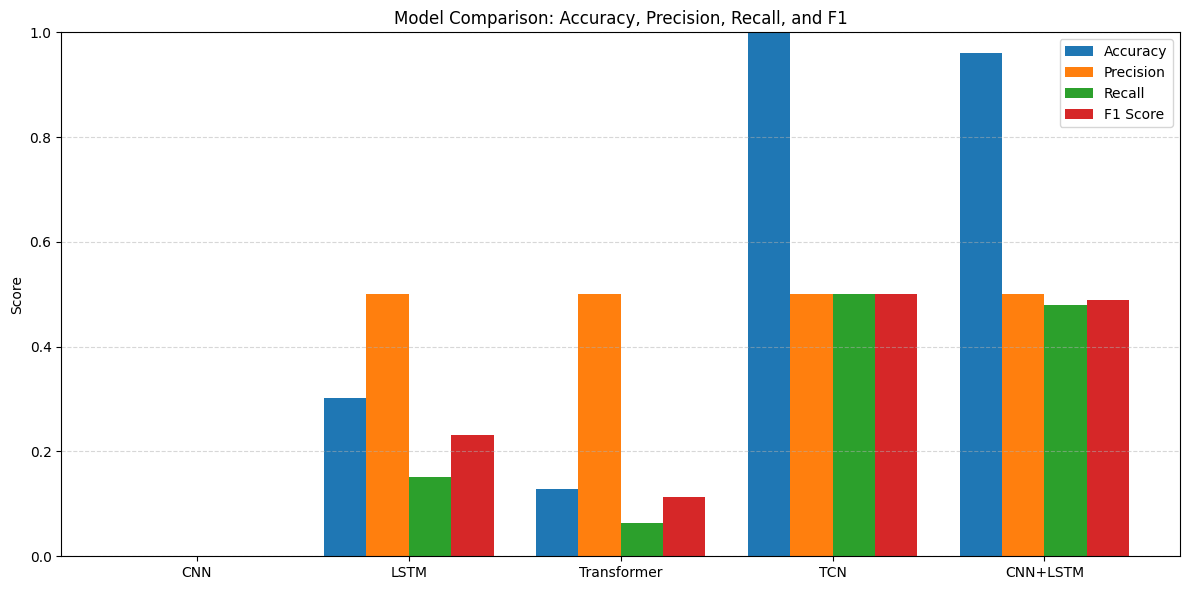

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Extract values from metrics_df
models = metrics_df.index.tolist()
accuracy = metrics_df["Accuracy"].values
precision = metrics_df["Precision_macro"].values
recall = metrics_df["Recall_macro"].values
f1 = metrics_df["F1_macro"].values

# Grouped bar chart settings
x = np.arange(len(models))
width = 0.20

plt.figure(figsize=(12,6))

# Bars
plt.bar(x - 1.5*width, accuracy, width, label='Accuracy')
plt.bar(x - 0.5*width, precision, width, label='Precision')
plt.bar(x + 0.5*width, recall, width, label='Recall')
plt.bar(x + 1.5*width, f1, width, label='F1 Score')

# Labels & formatting
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy, Precision, Recall, and F1')
plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


CONFUSION MATRIX

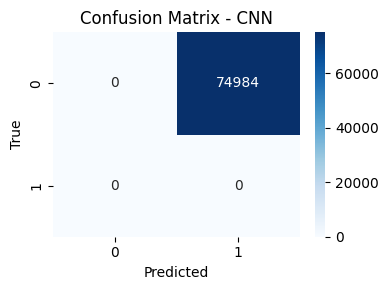

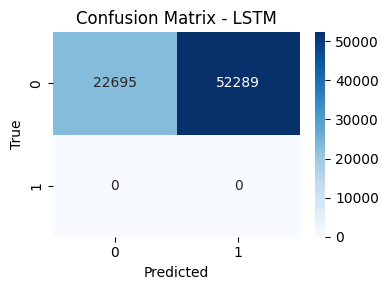

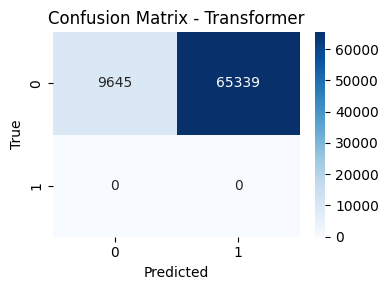

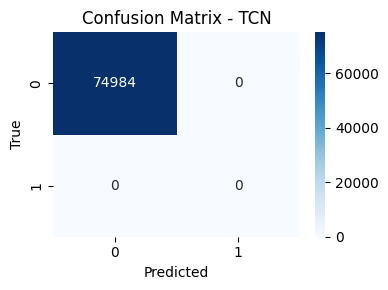

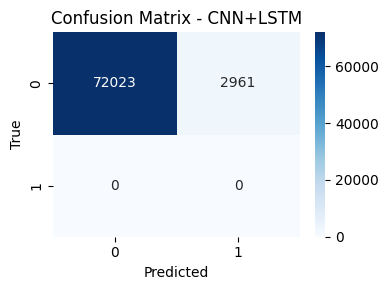

In [24]:
for name, model in models_to_compare.items():
    y_true, y_pred = get_predictions(model, test_loader)
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=unique_labels,
                yticklabels=unique_labels,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()



CLASS-WISE PROBABILITY DISTRIBUTIONS (PER MODEL)

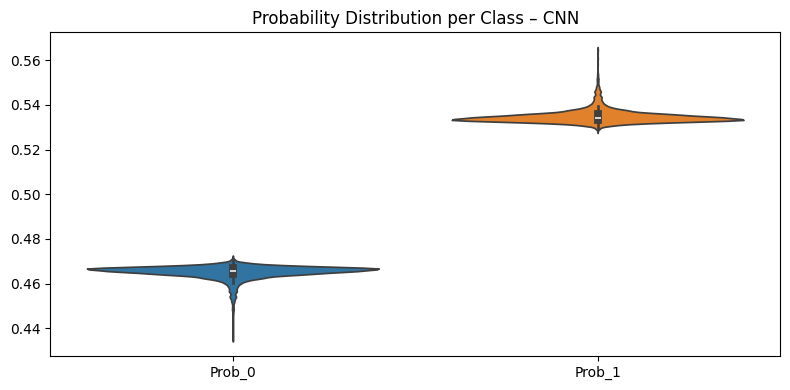

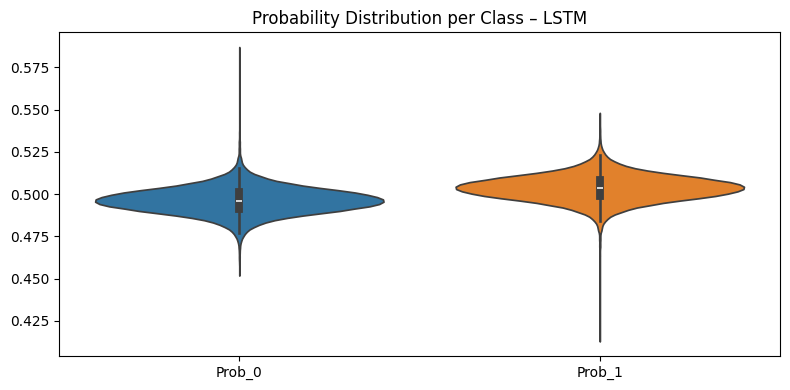

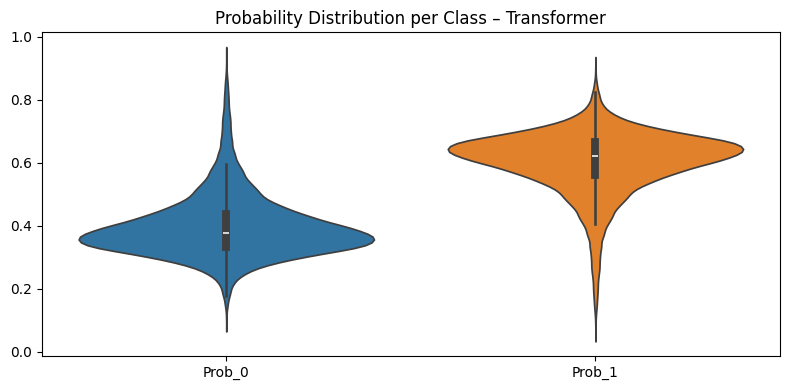

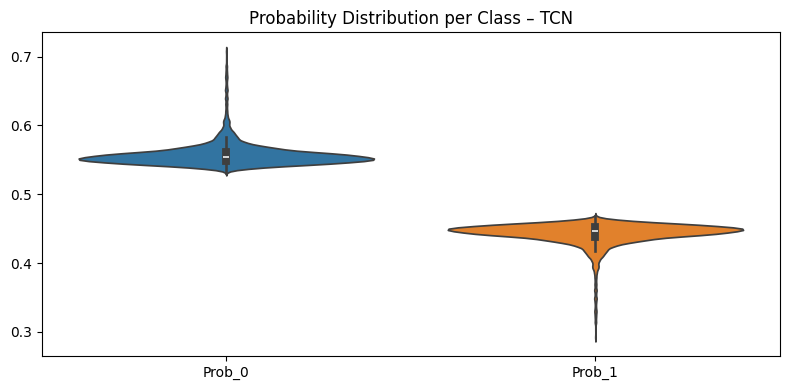

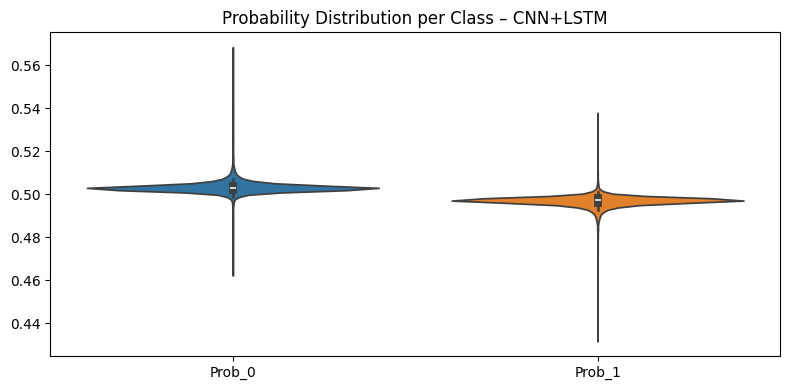

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_probability_distribution(model, name):
    probs = get_probabilities(model, test_loader)
    y_true, y_pred = get_predictions(model, test_loader)

    df_plot = pd.DataFrame(probs, columns=[f"Prob_{c}" for c in unique_labels])
    df_plot["True"] = y_true

    plt.figure(figsize=(8,4))
    sns.violinplot(data=df_plot.drop(columns="True"))
    plt.title(f"Probability Distribution per Class – {name}")
    plt.tight_layout()
    plt.show()

plot_probability_distribution(cnn_model, "CNN")
plot_probability_distribution(lstm_model, "LSTM")
plot_probability_distribution(transformer_model, "Transformer")
plot_probability_distribution(tcn_model, "TCN")
plot_probability_distribution(cnnlstm_model, "CNN+LSTM")


SHAP EXPLAINABILITY FOR ALL MODELS

In [38]:
import torch
torch.backends.cudnn.enabled = False


Computing SHAP for CNN
CNN: global_importance shape = (2,), feature_cols length = 157


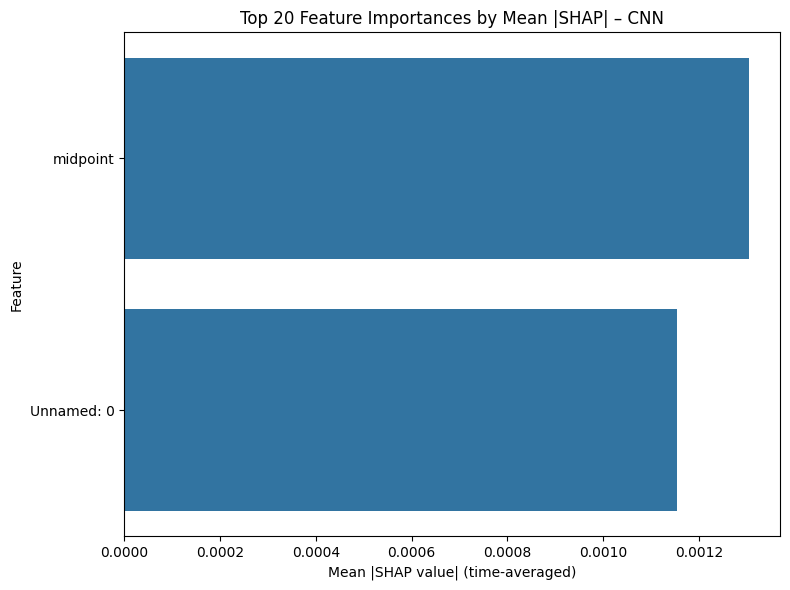


Computing SHAP for LSTM


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


LSTM: global_importance shape = (2,), feature_cols length = 157


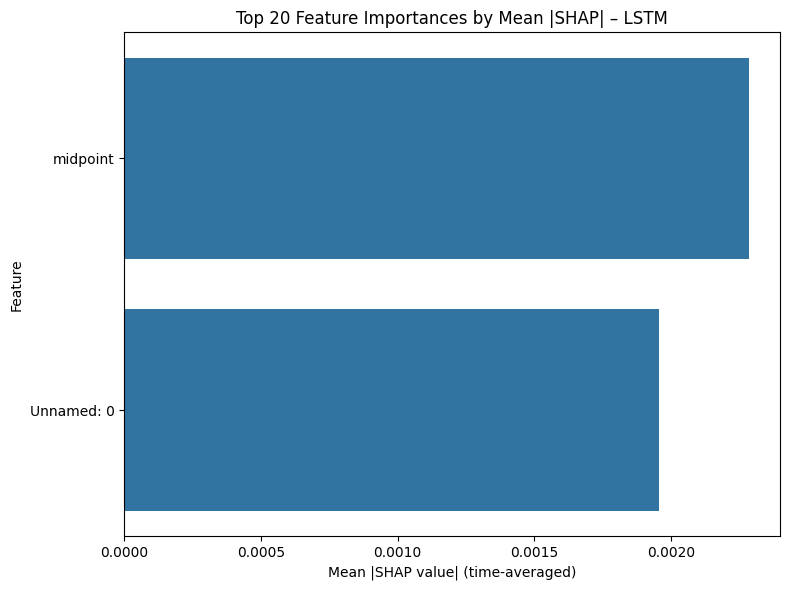


Computing SHAP for Transformer


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: PositionalEncoding
  warnings.warn(f"unrecognized nn.Module: {module_type}")


Transformer: global_importance shape = (2,), feature_cols length = 157


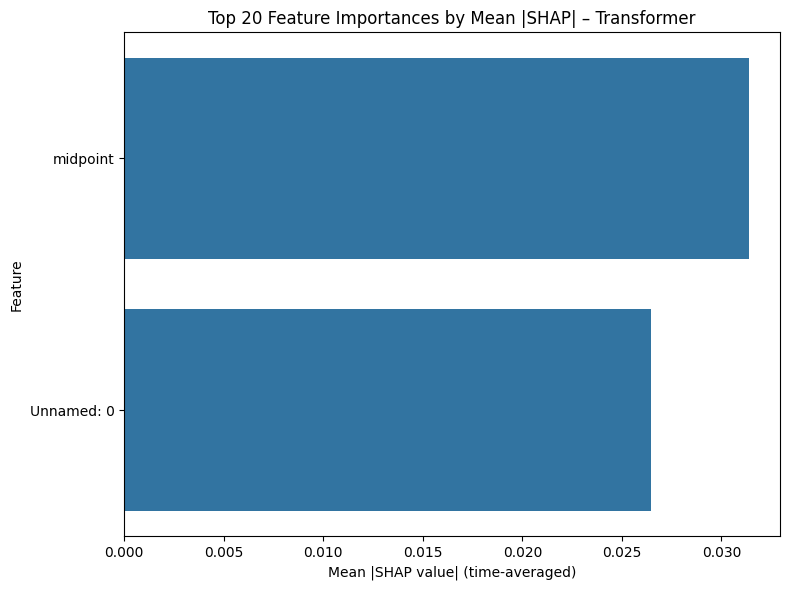


Computing SHAP for TCN


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: Chomp1d
  warnings.warn(f"unrecognized nn.Module: {module_type}")


TCN: global_importance shape = (2,), feature_cols length = 157


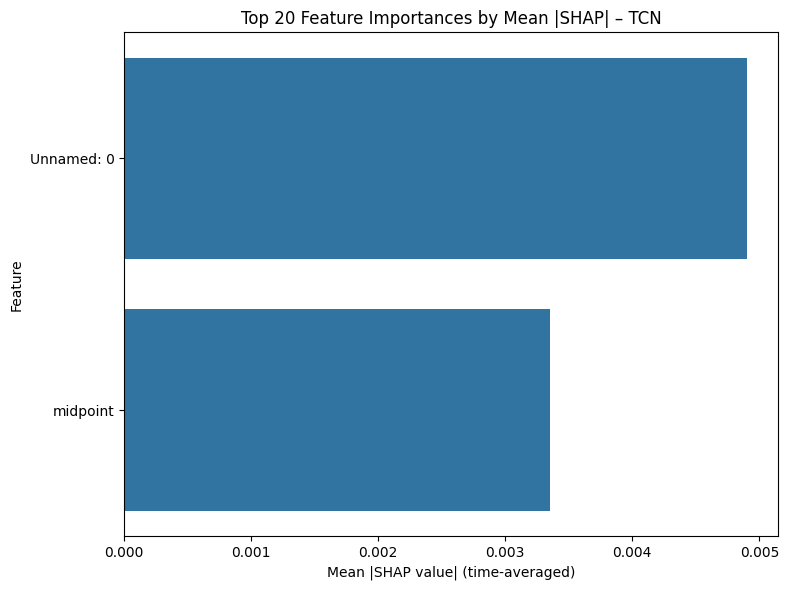


Computing SHAP for CNN+LSTM


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


CNN+LSTM: global_importance shape = (2,), feature_cols length = 157


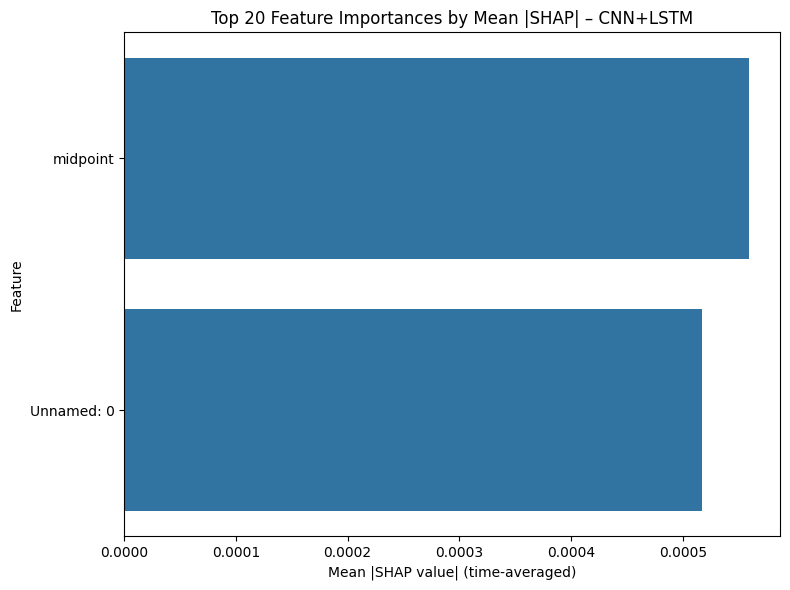

In [39]:
!pip install -q shap
import shap
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Helper: sample sequences from test_ds ----------
def build_sequence_arrays(dataset, n_samples=200):
    n = len(dataset)
    idxs = random.sample(range(n), min(n_samples, n))

    seq_list = []
    agg_list = []
    y_list = []

    for i in idxs:
        x, y = dataset[i]           # x: [T, F]
        x_np = x.numpy()
        seq_list.append(x_np)
        agg_list.append(x_np.mean(axis=0))
        y_list.append(y.item())

    X_seq = torch.tensor(np.stack(seq_list), dtype=torch.float32).to(device)
    X_agg = np.stack(agg_list)
    y_idx = np.array(y_list)

    return X_seq, X_agg, y_idx

# Shared background + test set for SHAP
background_seq, background_agg, _ = build_sequence_arrays(test_ds, n_samples=50)
test_seq, test_agg, test_y_idx = build_sequence_arrays(test_ds, n_samples=200)

# ---------- 2. Models to explain ----------
models_to_explain = {
    "CNN": cnn_model,
    "LSTM": lstm_model,
    "Transformer": transformer_model,
    "TCN": tcn_model,
    "CNN+LSTM": cnnlstm_model
}

for m in models_to_explain.values():
    m.eval()

# ---------- 3. SHAP loop ----------
shap_importances = {}

for model_name, model in models_to_explain.items():

    print("\n============================")
    print(f"Computing SHAP for {model_name}")
    print("============================")

    # Save original mode (train/eval)
    was_training = model.training

    # IMPORTANT: DeepExplainer needs backward through RNN -> use train() mode
    model.train()

    # Create DeepExplainer
    explainer = shap.DeepExplainer(
        model,
        background_seq
    )

    # Compute SHAP values (disable additivity check)
    shap_values_list = explainer.shap_values(
        test_seq,
        check_additivity=False
    )

    # Restore original mode
    if not was_training:
        model.eval()

    # Sum absolute contributions across classes
    shap_abs_sum = np.zeros_like(shap_values_list[0])
    for sv in shap_values_list:
        shap_abs_sum += np.abs(sv)

    # Aggregate over time -> [N, F]
    shap_agg = shap_abs_sum.mean(axis=1)

    # Global importance over samples -> [F]
    global_importance = shap_agg.mean(axis=0)

    print(f"{model_name}: global_importance shape = {global_importance.shape}, "
          f"feature_cols length = {len(feature_cols)}")

    n_feat_importance = global_importance.shape[0]
    n_feat_names = len(feature_cols)

    if n_feat_importance != n_feat_names:
        print(f"WARNING: feature length mismatch for {model_name}. "
              f"Using min({n_feat_importance}, {n_feat_names}).")
        k = min(n_feat_importance, n_feat_names)
        feat_names = feature_cols[:k]
        global_importance = global_importance[:k]
    else:
        feat_names = feature_cols

    importance_df = pd.DataFrame({
        "feature": feat_names,
        "importance": global_importance
    }).sort_values("importance", ascending=False)

    shap_importances[model_name] = importance_df

    # Plot top 20 SHAP features
    plt.figure(figsize=(8,6))
    sns.barplot(
        data=importance_df.head(20),
        x="importance",
        y="feature",
        orient="h"
    )
    plt.title(f"Top 20 Feature Importances by Mean |SHAP| – {model_name}")
    plt.xlabel("Mean |SHAP value| (time-averaged)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

RADAR PLOT COMPARING MODELS

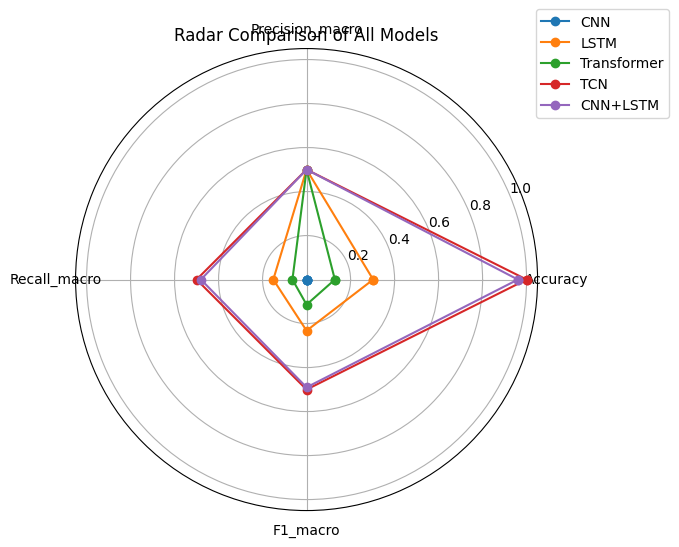

In [41]:
from math import pi

df_radar = metrics_df.copy()
categories = df_radar.columns.tolist()
models = df_radar.index.tolist()

plt.figure(figsize=(6,6))
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

for m in models:
    values = df_radar.loc[m].tolist()
    values += values[:1]
    plt.polar(angles, values, marker='o', label=m)

plt.xticks(angles[:-1], categories)
plt.title("Radar Comparison of All Models")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

CALIBRATION DISTRIBUTION (ECE-EXPECTED CALIBRATION ERROR)

In [43]:
def expected_calibration_error(model, loader=test_loader, bins=15):
    probs = get_probabilities(model, loader)
    conf = probs.max(axis=1)
    y_true, y_pred = get_predictions(model, loader)
    correct = (y_true == y_pred).astype(int)

    bin_bounds = np.linspace(0, 1, bins+1)
    ece = 0.0

    for i in range(bins):
        lower, upper = bin_bounds[i], bin_bounds[i+1]
        idx = (conf >= lower) & (conf < upper)
        if idx.sum() == 0:
            continue
        ece += abs(correct[idx].mean() - conf[idx].mean()) * idx.mean()

    return ece

for name, model in models_to_compare.items():
    print(name, "ECE:", expected_calibration_error(model))

CNN ECE: 0.5347795343050564
LSTM ECE: 0.20405988018591326
Transformer ECE: 0.4989185646115926
TCN ECE: 0.4423142166252415
CNN+LSTM ECE: 0.4572329701319024


FINAL SUMMARY DASHBOARD TABLE

In [44]:
summary = pd.DataFrame(columns=["Accuracy","F1","ECE","Stability","Misclassifications"])

for name, model in models_to_compare.items():
    y_t, y_p = get_predictions(model, test_loader)
    summary.loc[name,"Accuracy"] = accuracy_score(y_t, y_p)
    summary.loc[name,"F1"] = precision_recall_fscore_support(y_t, y_p, average="macro")[2]
    summary.loc[name,"ECE"] = expected_calibration_error(model)
    summary.loc[name,"Stability"] = batch_variance(model)
    summary.loc[name,"Misclassifications"] = (y_t != y_p).sum()

summary

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classifi

,Accuracy,F1,ECE,Stability,Misclassifications
CNN,0.0,0.0,0.53478,0.0,74984
LSTM,0.302665,0.232343,0.20406,0.019867,52289
Transformer,0.128627,0.113968,0.498919,0.01193,65339
TCN,1.0,1.0,0.442314,0.0,0
CNN+LSTM,0.960512,0.489929,0.457233,0.001617,2961
